In [1]:
from unet_project.image_utils import ImageUtils
from unet_project.data_augmentation import DataAugmentation
from unet_project.u_net import Unet
from unet_project.create_patches import PatchesCreator
from skimage.io import imshow
from matplotlib import pyplot as plt
import numpy as np
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow
from matplotlib import pyplot as plt
import random
from keras.models import load_model
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
path_to_imgs = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/imgs/'
path_to_masks = '/home/ajuska/Dokumenty/Skola/diplomka/custom_train/masks/'
img_height = 224
img_width = 224
img_channels = 3

image_utils = ImageUtils(path_to_imgs, path_to_masks, img_height, img_width)
imgs_masks = image_utils.get_preprocessed_images()

# data_augmentor = DataAugmentation(imgs_masks, how_many=1)
# aug_imgs, aug_masks = data_augmentor.extend_database()

imgs = []
masks = []
for key, val in tqdm_notebook(imgs_masks.items()):
    imgs.append(val[0])
    masks.append(val[1])

patches_creator = PatchesCreator(imgs, masks, img_height, img_width)
img_p, mask_p = patches_creator.create_patches()

 16%|█▌        | 18/116 [00:00<00:00, 173.00it/s]

Loading images.


100%|██████████| 116/116 [00:01<00:00, 74.61it/s]



Loading masks.


100%|██████████| 116/116 [00:00<00:00, 172470.49it/s]


Preprocessing images.



Creating patches.


In [3]:
trainX = np.array([x/255 for x in img_p])
trainY = np.array([x/255 for x in mask_p])

In [4]:
trainY.shape

(1740, 224, 224, 1)

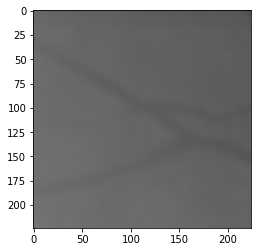

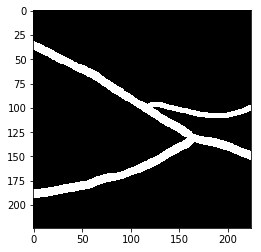

In [5]:
plt.figure()
plt.imshow(trainX[90])
plt.figure()
plt.imshow(np.squeeze(trainY[90]), cmap='gray')

In [6]:
unet = Unet(img_height=img_height, img_width=img_width, img_channels=img_channels)
model = unet.create_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-test.h5', verbose=1, save_best_only=True)
results = model.fit(trainX, trainY, validation_split=0.1, batch_size=32, epochs=50,
                    callbacks=[earlystopper, checkpointer])

Creating model.
Train on 1566 samples, validate on 174 samples
Epoch 1/50
 512/1566 [========>.....................] - ETA: 19:34 - loss: 0.5878 - acc: 0.7090

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ajuska/Dokumenty/Skola/diplomka/diplomka/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-caf1edad5829>", line 6, in <module>
    callbacks=[earlystopper, checkpointer])
  File "/home/ajuska/Dokumenty/Skola/diplomka/diplomka/lib/python3.5/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/home/ajuska/Dokumenty/Skola/diplomka/diplomka/lib/python3.5/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/home/ajuska/Dokumenty/Skola/diplomka/diplomka/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/home/ajuska/Dokumenty/Skola/diplomka/diplomka/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._

KeyboardInterrupt: 

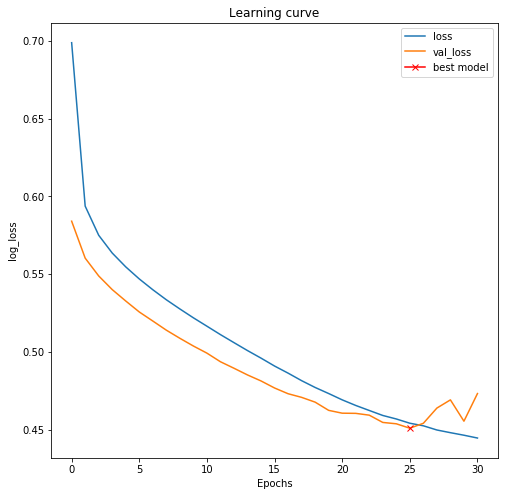

In [11]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [23]:
preds = model.predict(trainX[10:20])
preds_t = (preds > 0.13)

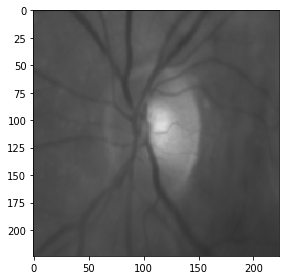

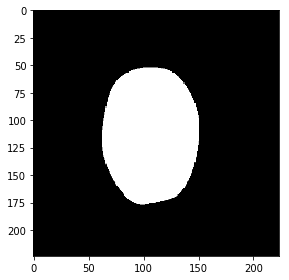

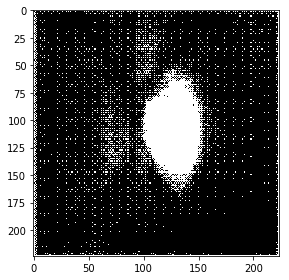

In [25]:
imshow(trainX[15])
plt.show()
imshow(np.squeeze(trainY[15]))
plt.show()
imshow(np.squeeze(preds_t[5]))
plt.show()